# Binary Image Classification Deep Learning Model for Chest X-Ray Pneumonia Images Using TensorFlow Take 5
### David Lowe
### February 4, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Chest X-Ray Pneumonia dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The dataset contains chest X-ray images that were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. The image collection is organized into three folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images with various display resolutions in this collection.

From iteration Take1, we trained a simple three-layer CNN model and used the model’s performance as the baseline.

From iteration Take2, we used the same three-layer CNN model from Take1 and applied it to the same photos with a higher resolution (from 640x480 to 1024x768).

From iteration Take3, we constructed a VGG-16 CNN model and compared it with the baseline model.

From iteration Take4, we constructed an Inception V3 CNN model and compared it with the baseline model.

In this Take5 iteration, we will construct a MobileNetV3Large CNN model and compare it with the baseline model.

ANALYSIS: From iteration Take1, the baseline model's performance achieved an accuracy score of 100% after 20 epochs using the validation dataset. However, the final model processed the test dataset with an accuracy measurement of only 72.91%.

From iteration Take2, the model's performance achieved an accuracy score of 62.50% after ten epochs using the validation dataset. However, the final model processed the test dataset with an encouraging accuracy measurement of 83.33%.

From iteration Take3, the VGG-16 model's performance achieved an accuracy score of 87.50% after ten epochs using the validation dataset. However, the final model processed the test dataset with an encouraging accuracy measurement of 76.44%.

From iteration Take4, the Inception v3 model's performance achieved an accuracy score of 68.75% after 20 epochs using the validation dataset. Moreover, the final model processed the test dataset with an encouraging accuracy measurement of 67.95%.

In this Take5 iteration, the MobileNetV3Large model's performance achieved an accuracy score of 100% after 10 epochs using the validation dataset. Moreover, the final model processed the test dataset with an encouraging accuracy measurement of 77.72%.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset, but we need to experiment with the TensorFlow model further to improve its accuracy.

Dataset Used: Chest X-Ray Images (Pneumonia) Dataset

Dataset ML Model: Binary image classification with numerical attributes

Dataset References: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia, https://data.mendeley.com/datasets/rscbjbr9sj/2, and http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5.

One potential source of performance benchmarks: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jan 29 16:36:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
# DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.GlorotUniform(seed=seedNum)
EPOCH_NUMBER = 10
BATCH_SIZE = 1
IMAGE_SIZE = (800, 600)
IMAGE_SHAPE = (800, 600, 3)

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm chest_xray.zip

rm: cannot remove 'chest_xray.zip': No such file or directory


In [15]:
!wget https://dainesanalytics.com/datasets/kaggle-chest-xray-pneumonia/chest_xray.zip

--2021-01-29 16:36:42--  https://dainesanalytics.com/datasets/kaggle-chest-xray-pneumonia/chest_xray.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.2.12, 13.224.2.15, 13.224.2.43, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.2.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225760319 (1.1G) [application/zip]
Saving to: ‘chest_xray.zip’

chest_xray.zip      100%[===================>]   1.14G   190MB/s    in 6.3s    

2021-01-29 16:36:49 (185 MB/s) - ‘chest_xray.zip’ saved [1225760319/1225760319]



In [16]:
staging_dir = 'staging/'
!mkdir staging/

In [17]:
local_zip = 'chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
zip_ref.close()

In [18]:
training_dir = 'staging/chest_xray/train/'
validation_dir = 'staging/chest_xray/val/'
classA_name = 'NORMAL'
classB_name = 'PNEUMONIA'

In [19]:
# Brief listing of training image files for class A
training_classA_dir = os.path.join(training_dir, classA_name)
training_classA_files = os.listdir(training_classA_dir)
print('Number of training images for', classA_name, ':', len(os.listdir(training_classA_dir)))
print('Training samples for', classA_name, ':', training_classA_files[:10])

# Brief listing of training image files for class B
training_classB_dir = os.path.join(training_dir, classB_name)
training_classB_files = os.listdir(training_classB_dir)
print('Number of training images for', classB_name, ':', len(os.listdir(training_classB_dir)))
print('Training samples for', classB_name, ':', training_classB_files[:10])

Number of training images for NORMAL : 1341
Training samples for NORMAL : ['IM-0635-0001.jpeg', 'NORMAL2-IM-0601-0001.jpeg', 'IM-0640-0001-0001.jpeg', 'IM-0750-0001.jpeg', 'IM-0541-0001.jpeg', 'IM-0553-0001-0002.jpeg', 'NORMAL2-IM-0649-0001.jpeg', 'NORMAL2-IM-0563-0001.jpeg', 'IM-0187-0001.jpeg', 'IM-0248-0001.jpeg']
Number of training images for PNEUMONIA : 3875
Training samples for PNEUMONIA : ['person548_bacteria_2298.jpeg', 'person1329_bacteria_3377.jpeg', 'person26_bacteria_123.jpeg', 'person1924_bacteria_4832.jpeg', 'person975_virus_1650.jpeg', 'person1318_virus_2274.jpeg', 'person525_virus_1046.jpeg', 'person619_bacteria_2490.jpeg', 'person438_virus_889.jpeg', 'person554_bacteria_2320.jpeg']


In [20]:
# Brief listing of validation image files for class A
validation_classA_dir = os.path.join(validation_dir, classA_name)
validation_classA_files = os.listdir(validation_classA_dir)
print('Number of validation images for', classA_name, ':', len(os.listdir(validation_classA_dir)))
print('Validation samples for', classA_name, ':', validation_classA_files[:10])

# Brief listing of validation image files for class B
validation_classB_dir = os.path.join(validation_dir, classB_name)
validation_classB_files = os.listdir(validation_classB_dir)
print('Number of validation images for', classB_name, ':', len(os.listdir(validation_classB_dir)))
print('Validation samples for', classB_name, ':', validation_classB_files[:10])

Number of validation images for NORMAL : 8
Validation samples for NORMAL : ['NORMAL2-IM-1436-0001.jpeg', 'NORMAL2-IM-1437-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1440-0001.jpeg', 'NORMAL2-IM-1438-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1431-0001.jpeg']
Number of validation images for PNEUMONIA : 8
Validation samples for PNEUMONIA : ['person1951_bacteria_4882.jpeg', 'person1952_bacteria_4883.jpeg', 'person1949_bacteria_4880.jpeg', 'person1947_bacteria_4876.jpeg', 'person1950_bacteria_4881.jpeg', 'person1946_bacteria_4875.jpeg', 'person1954_bacteria_4886.jpeg', 'person1946_bacteria_4874.jpeg']


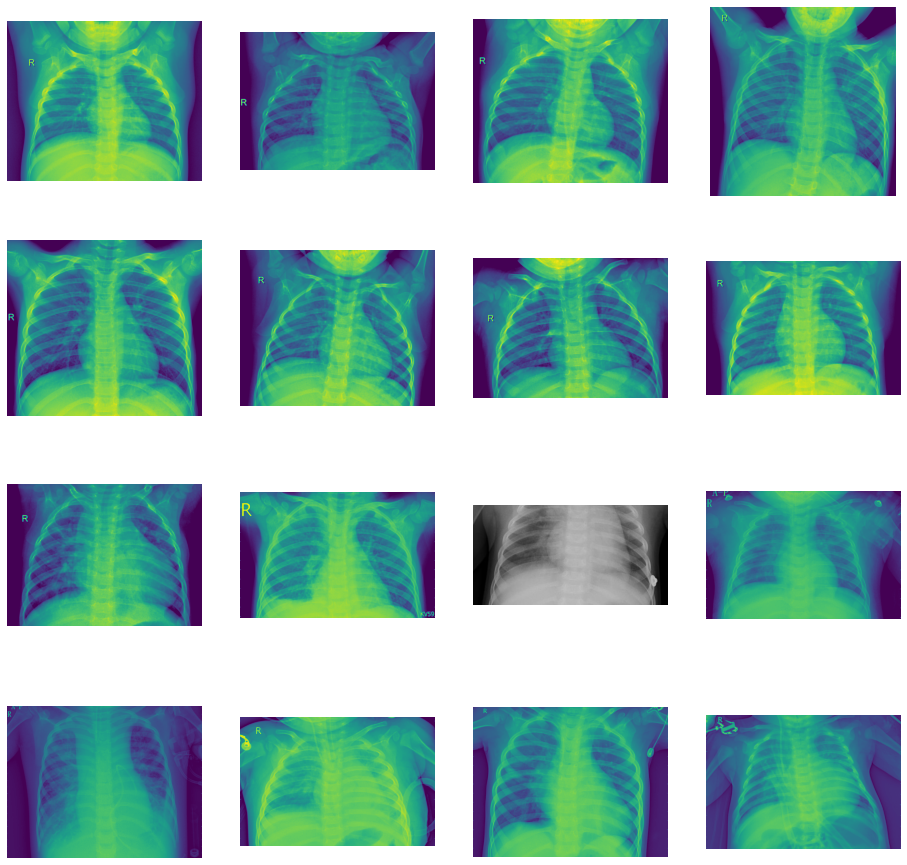

In [21]:
# Plot some training images from the dataset
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

reset_random(seedNum)
number_elements = ncols * 2
random_training_classA = random.sample(training_classA_files, number_elements)
random_training_classB = random.sample(training_classB_files, number_elements)
next_classA = [os.path.join(training_classA_dir, fname) for fname in random_training_classA]
next_classB = [os.path.join(training_classB_dir, fname) for fname in random_training_classB]

for i, img_path in enumerate(next_classA + next_classB):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [22]:
print('Loading and pre-processing the training images...')
training_datagen = ImageDataGenerator(rescale=1/255)
# training_datagen = ImageDataGenerator(rescale=1/255, preprocessing_function=tf.image.rgb_to_grayscale)
# training_datagen = ImageDataGenerator(rescale=1./255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.1, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     fill_mode='nearest')
training_generator = training_datagen.flow_from_directory(training_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
print('Number of training image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 5216 images belonging to 2 classes.
Number of training image batches per epoch of modeling: 5216


In [23]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
# validation_datagen = ImageDataGenerator(rescale=1/255, preprocessing_function=tf.image.rgb_to_grayscale)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)
print('Number of valdiation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Found 16 images belonging to 2 classes.
Number of valdiation image batches per epoch of modeling: 16


In [24]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [25]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [27]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=IMAGE_SHAPE, output_param=1, opt_param=DEFAULT_OPTIMIZER, init_param=DEFAULT_INITIALIZER, loss_param=DEFAULT_LOSS, metrics_paranm=DEFAULT_METRICS):
    nn_model = keras.applications.MobileNetV3Large(include_top=True, weights=None, input_shape=input_param, classes=output_param, classifier_activation='sigmoid')
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_paranm)
    return nn_model

In [28]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCH_NUMBER,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/10
5216/5216 [==============================] - 391s 73ms/step - loss: 0.5298 - accuracy: 0.7513 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/10
5216/5216 [==============================] - 381s 73ms/step - loss: 0.2352 - accuracy: 0.9261 - val_loss: 0.6696 - val_accuracy: 0.5000
Epoch 3/10
5216/5216 [==============================] - 379s 73ms/step - loss: 0.1405 - accuracy: 0.9517 - val_loss: 0.5638 - val_accuracy: 0.6875
Epoch 4/10
5216/5216 [==============================] - 380s 73ms/step - loss: 0.0920 - accuracy: 0.9688 - val_loss: 0.1736 - val_accuracy: 1.0000
Epoch 5/10
5216/5216 [==============================] - 379s 73ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.9545 - val_accuracy: 0.5625
Epoch 6/10
5216/5216 [==============================] - 379s 73ms/step - loss: 0.0676 - accuracy: 0.9785 - val_loss: 0.4402 - val_accuracy: 0.6875

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
5216/5216 [===============

In [29]:
nn_model_0.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 800, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 400, 300, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 400, 300, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

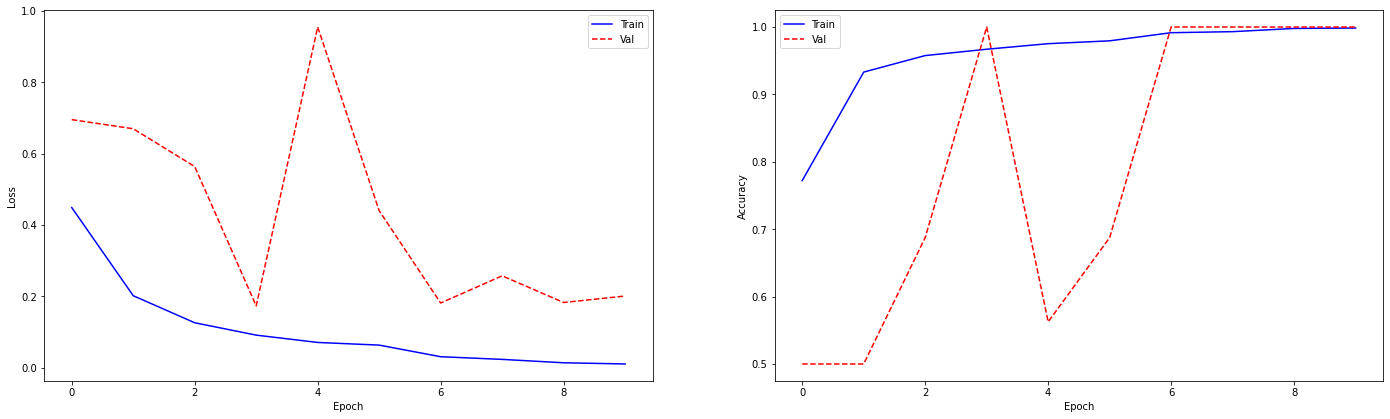

In [30]:
plot_metrics(nn_model_history)

In [31]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [32]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [33]:
# Not applicable for this iteration of modeling

In [34]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [35]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [36]:
final_model = nn_model_0

# Display a summary of the final model
final_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 800, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 400, 300, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 400, 300, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [37]:
print('Loading and pre-processing the test images...')
testing_dir = 'staging/chest_xray/test/'
testing_datagen = ImageDataGenerator(rescale=1/255)
# testing_datagen = ImageDataGenerator(rescale=1/255, preprocessing_function=tf.image.rgb_to_grayscale)
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)
print('Number of testing image batches per epoch of modeling:', len(testing_generator))

Loading and pre-processing the test images...
Found 624 images belonging to 2 classes.
Number of testing image batches per epoch of modeling: 624


In [38]:
# Print the labels used for the modeling
print(testing_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [39]:
final_model.evaluate(testing_generator, verbose=1)

624/624 [==============================] - 10s 16ms/step - loss: 0.7047 - accuracy: 0.7772


[0.7047435641288757, 0.7772436141967773]

In [40]:
test_pred = final_model.predict(testing_generator)
test_predictions = (test_pred > 0.5).astype('int').ravel()
test_original = testing_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.7772435897435898
[[129 105]
 [ 34 356]]
              precision    recall  f1-score   support

           0       0.79      0.55      0.65       234
           1       0.77      0.91      0.84       390

    accuracy                           0.78       624
   macro avg       0.78      0.73      0.74       624
weighted avg       0.78      0.78      0.77       624



In [41]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [42]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:04:16.284497
